In [143]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import numpy as np
rs = RandomState(MT19937(SeedSequence(2 ** 31 - 1)))
def reseed():
    global rs
    np.random.seed(2 ** 31 - 1)
    rs = RandomState(MT19937(SeedSequence(2 ** 31 - 1)))

In [126]:
# This is sourced from https://github.com/felixpatzelt/colorednoise/blob/master/colorednoise.py
# Accessed: 17.11.2025
from typing import Union, Iterable, Optional
from numpy import sqrt, newaxis, integer
from numpy.fft import irfft, rfftfreq
from numpy.random import default_rng, Generator, RandomState
from numpy import sum as npsum


def powerlaw_psd_gaussian(
        exponent: float, 
        size: Union[int, Iterable[int]], 
        fmin: float = 0.0, 
        random_state: Optional[Union[int, Generator, RandomState]] = None
    ):
    """Gaussian (1/f)**beta noise.

    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)

    Normalised to unit variance

    Parameters:
    -----------

    exponent : float
        The power-spectrum of the generated noise is proportional to

        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2

        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.

    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.

    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. 
        
        The power-spectrum below fmin is flat. fmin is defined relative
        to a unit sampling rate (see numpy's rfftfreq). For convenience,
        the passed value is mapped to max(fmin, 1/samples) internally
        since 1/samples is the lowest possible finite frequency in the
        sample. The largest possible value is fmin = 0.5, the Nyquist
        frequency. The output for this value is white noise.

    random_state :  int, numpy.integer, numpy.random.Generator, numpy.random.RandomState, 
                    optional
        Optionally sets the state of NumPy's underlying random number generator.
        Integer-compatible values or None are passed to np.random.default_rng.
        np.random.RandomState or np.random.Generator are used directly.
        Default: None.

    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    if isinstance(size, (integer, int)):
        size = [size]
    elif isinstance(size, Iterable):
        size = list(size)
    else:
        raise ValueError("Size must be of type int or Iterable[int]")
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples) # type: ignore # mypy 1.5.1 has problems here 
    
    # Validate / normalise fmin
    if 0 <= fmin <= 0.5:
        fmin = max(fmin, 1./samples) # Low frequency cutoff
    else:
        raise ValueError("fmin must be chosen between 0 and 0.5.")
    
    # Build scaling factors for all frequencies
    s_scale = f    
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # prepare random number generator
    normal_dist = _get_normal_distribution(random_state)

    # Generate scaled random power + phase
    sr = normal_dist(scale=s_scale, size=size)
    si = normal_dist(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2):
        si[..., -1] = 0
        sr[..., -1] *= sqrt(2)    # Fix magnitude
    
    # Regardless of signal length, the DC component must be real
    si[..., 0] = 0
    sr[..., 0] *= sqrt(2)    # Fix magnitude
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y


def _get_normal_distribution(random_state: Optional[Union[int, Generator, RandomState]]):
    normal_dist = None
    if isinstance(random_state, (integer, int)) or random_state is None:
        random_state = default_rng(random_state)
        normal_dist = random_state.normal
    elif isinstance(random_state, (Generator, RandomState)):
        normal_dist = random_state.normal
    else:
        raise ValueError(
            "random_state must be one of integer, numpy.random.Generator, "
            "numpy.random.Randomstate"
        )
    return normal_dist

In [ ]:
import numpy as np
# Method mentioned in timmer95 eq. 1
def timmer95_noise_naive(
        exponent: float,
        size: int
    ):
    freqs = [(2 * np.pi * k) / size for k in range(0, size)]
    S = [0 if i == 0 else 1.0 / (freqs[i] ** exponent) for i in range(0, len(freqs)//2)]

    phases = np.random.uniform(0, 2 * np.pi, len(freqs))

    A = np.sqrt(S)
    x = [np.sum(A[i] * np.cos(freqs[i] * t - phases[i]) for i in range(0, len(freqs)//2)) for t in range(0, size)]
    return x

def timmer95_noise(
        exponent: float,
        size: int
    ):
    freqs = 2 * np.pi * np.arange(0, size//2) / size

    S = np.zeros(len(freqs))
    S[0] = 0
    S[1:] = freqs[1:] ** (-exponent)

    phases = rs.uniform(0, 2 * np.pi, len(freqs), )

    A = np.sqrt(S)
    x = [np.sum(A * np.cos(freqs * t - phases)) for t in range(0, size)]
    return x

In [ ]:
def f_alpha_noise(
        beta: float,
        size: int,
        p: int = None,
        Q: float = 1.0,
    ):

    if p == None:
        p = size + 1
    Q_d = np.sqrt(Q)
    hfa = np.zeros(2 * size + 1)
    wfa = np.zeros(2 * size + 1)
    hfa[1]=1.0
    wfa[:size + 1] = Q_d * rs.normal(size = size + 1)
    for i in range(2, p):
        hfa[i] = hfa[i-1] * (beta / 2.0 + i - 2)/(i - 1)
    for i in range(size + 1, 2 * size + 1):
        hfa[i] = 0.0
        wfa[i] = 0.0
    hfa_fft = np.fft.rfft(hfa[1:2*size+1])
    wfa_fft = np.fft.rfft(wfa[1:2*size+1])

    wfa_fft[0] *= hfa_fft[0]
    wfa_fft[1:] *= hfa_fft[1:]

    # # Complex number multiplication
    # for i in range(1, size, 2):
    #     wr = wfa_fft[i]
    #     wi = wfa_fft[i+1]
    #     wfa_fft[i] = wr * hfa_fft[i] - wi*hfa_fft[i+1]
    #     wfa_fft[i+1] = wr * hfa_fft[i+1] + wi*hfa_fft[i]
    wfa = np.fft.irfft(wfa_fft)
    X = np.zeros(size)
    for i in range(size):
        X[i] = wfa[i] / size

    return X

In [ ]:
def ar_filter_noise(
        beta: float,
        size: int,
        p: int = None
    ):
    if p == None:
        p = size
    ak = [1.0]
    for k in range(1, p):
        ak.append((k - 1 - beta / 2)/k * ((ak[k-1])))
    w = rs.normal(size = size)
    xk = []
    for n in range(size):
        acc = 0.0
        for k in range(1, min(p, n)):
            acc -= ak[k] * xk[n - k]
        xk.append(w[n] + acc)
    return xk[:size]


In [2]:
# Source - https://stackoverflow.com/a
# Posted by A. Levy, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-21, License - CC BY-SA 4.0
def autocorrelation(x):
    conv = np.correlate(x, x, mode="full")
    return conv[conv.size//2:]

(1e-12, 1)

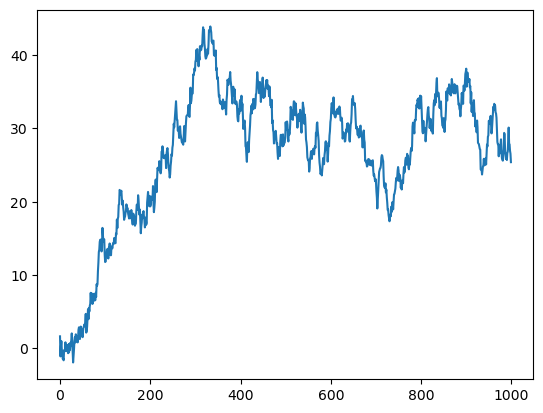

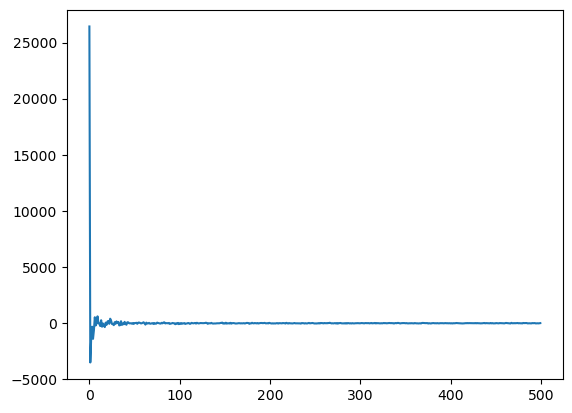

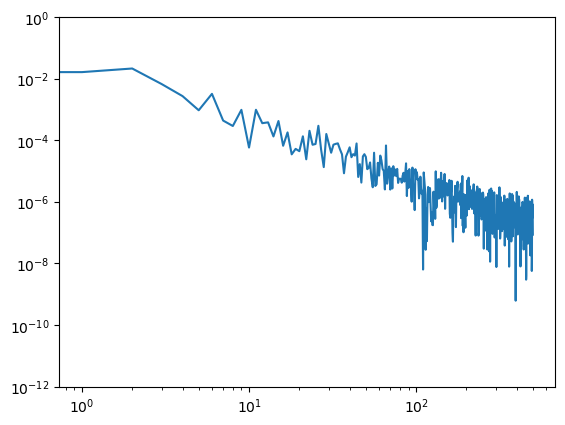

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import pprint 

n = 1000
T = 1.0 / n
reseed()
y = random_walk(0.001, n)
# y = f_alpha_noise(1, n)
frequency_y = np.fft.fft(y)
power = np.sum(np.abs(frequency_y) ** 2)
power_spectrum = (np.abs(frequency_y) ** 2 / (power))
# power_spectrum = (np.fft.fft(autocorrelation(y))) / power
# pprint.pprint(y)
# power_density_spectrum = power_spectrum / n
freqs = np.fft.fftfreq(n, T)
plt.figure()
plt.plot(y)
plt.figure()
plt.plot(freqs[:n//2], frequency_y[:n//2])
plt.figure()
plt.plot(freqs[:n//2], power_spectrum[:n//2])
# axs[3].plot(freqs[:n//2], power_density_spectrum[:n//2])
plt.yscale("log")
plt.xscale("log")
plt.ylim(10 ** -12, 1)

In [ ]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("powerlaw_timber", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("timeseries_done", lambda alpha, n: timmer95_noise(alpha, n)),
    ("f_alpha", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("ar_filter", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("ar_filter_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("ar_filter_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("ar_filter_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for (gen_name,gen) in generators:
    for alpha in [0, 0.5, 1, 1.5, 2]:
        reseed()
        start = time.time()
        y = gen(alpha, n)
        end = time.time()
        os.makedirs(os.path.dirname(f"../time/{n}/"), exist_ok = True)
        with open(f"../time/{n}/{gen_name}-{alpha}.yaml", 'w') as file:
            file.write(f"time: {end - start}")
        frequency_y = np.fft.fft(y)
        power = np.sum(np.abs(frequency_y) ** 2)
        power_spectrum = (np.abs(frequency_y) ** 2 / (power))
        freqs = np.fft.fftfreq(n, T)
        
        os.makedirs(os.path.dirname(f"../plots/{n}/"), exist_ok = True)
        plt.figure()
        plt.plot(y)
        plt.savefig(f"../plots/{n}/{gen_name}-{alpha}-noise.svg")
        plt.close()
        # plt.figure()
        # plt.plot(freqs[:n//2], frequency_y[:n//2])
        plt.figure()
        plt.plot(freqs[:n//2], power_spectrum[:n//2])
        plt.yscale("log")
        plt.xscale("log")
        plt.ylim(10 ** -12, 1)
        plt.savefig(f"../plots/{n}/{gen_name}-{alpha}-psd.svg")
        plt.close()


In [164]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("powerlaw_timber", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("timeseries_done", lambda alpha, n: timmer95_noise(alpha, n)),
    ("f_alpha", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("ar_filter", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("ar_filter_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("ar_filter_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("ar_filter_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for (gen_name,gen) in generators:
    for alpha in [0, 0.5, 1, 1.5, 2]:
        reseed()
        x = gen(alpha, n)

        os.makedirs(os.path.dirname(f"../plots/{n}/deviation/1d/"), exist_ok = True)
        plt.figure()
        plt.plot(x)
        plt.savefig(f"../plots/{n}/deviation/1d/{gen_name}-{alpha}-noise.svg")
        plt.close()

        x_sum = [np.sum(x[:i]) for i in range(0, len(x))]

        plt.figure()
        plt.plot(x_sum)
        plt.savefig(f"../plots/{n}/deviation/1d/{gen_name}-{alpha}-sum.svg")
        plt.close()

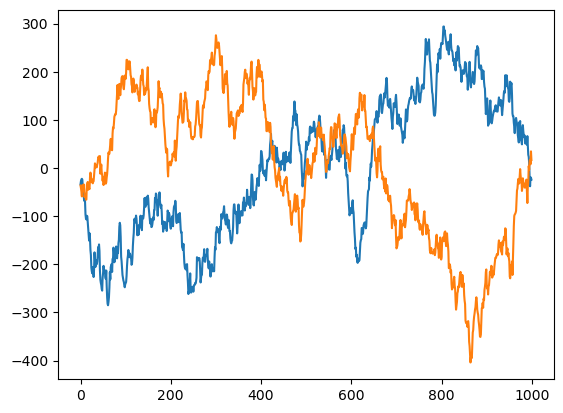

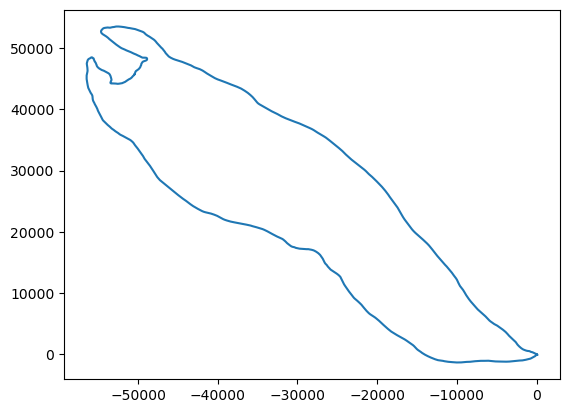

In [28]:
n = 1000
T = 1.0 / n
alpha = 2
x = timmer95_noise(alpha, n)
y = timmer95_noise(alpha, n)

plt.figure()
plt.plot(x)
plt.plot(y)

x_sum = [np.sum(x[:i]) for i in range(0, len(x))]
y_sum = [np.sum(y[:i]) for i in range(0, len(y))]

coordinates = zip(x_sum, y_sum)

plt.figure()
plt.plot(x_sum, y_sum)



In [151]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("powerlaw_timber", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("timeseries_done", lambda alpha, n: timmer95_noise(alpha, n)),
    ("f_alpha", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("ar_filter", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("ar_filter_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("ar_filter_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("ar_filter_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for (gen_name,gen) in generators:
    for alpha in [0, 0.5, 1, 1.5, 2]:
        reseed()
        x = gen(alpha, n)
        y = gen(alpha, n)

        os.makedirs(os.path.dirname(f"../plots/{n}/deviation/"), exist_ok = True)
        plt.figure()
        plt.plot(x)
        plt.plot(y)
        plt.savefig(f"../plots/{n}/deviation/{gen_name}-{alpha}-noise.svg")
        plt.close()

        x_sum = [np.sum(x[:i]) for i in range(0, len(x))]
        y_sum = [np.sum(y[:i]) for i in range(0, len(y))]

        plt.figure()
        plt.plot(x_sum, y_sum)
        plt.savefig(f"../plots/{n}/deviation/{gen_name}-{alpha}-sum.svg")
        plt.close()

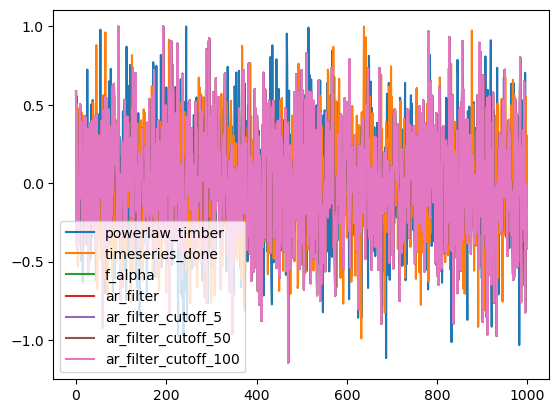

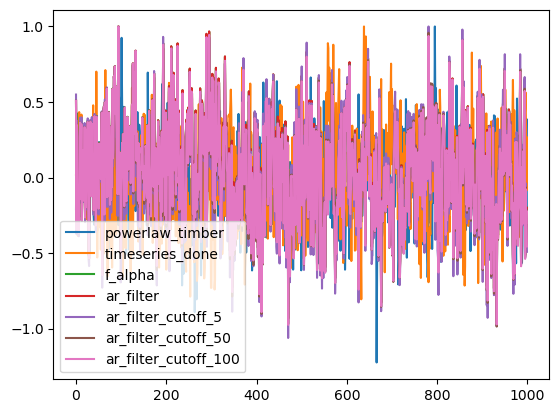

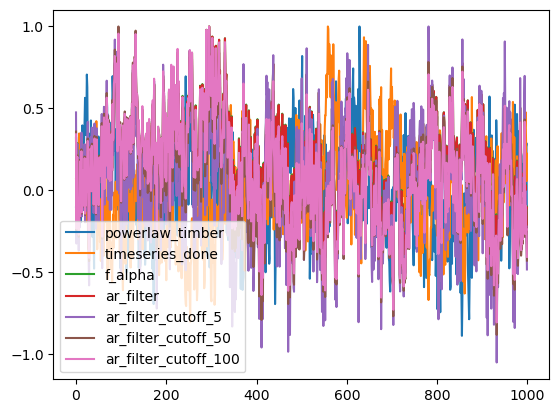

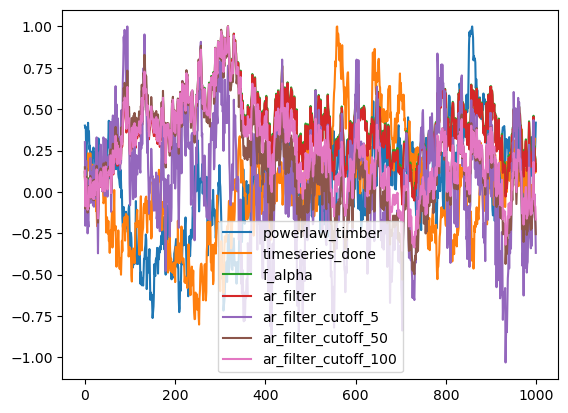

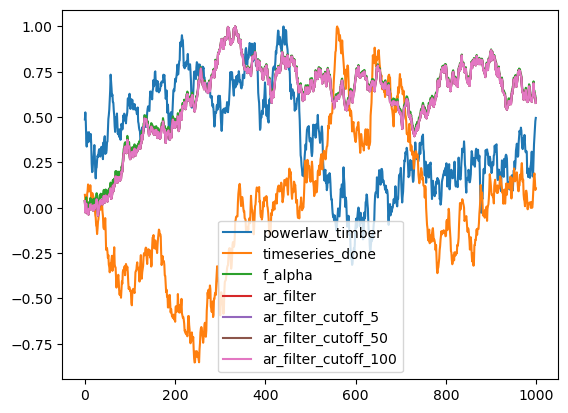

In [157]:
import os
import time
n = 1000
T = 1.0 / n
generators = [
    ("powerlaw_timber", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("timeseries_done", lambda alpha, n: timmer95_noise(alpha, n)),
    ("f_alpha", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("ar_filter", lambda alpha, n: ar_filter_noise(alpha, n)),
    ("ar_filter_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("ar_filter_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("ar_filter_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for alpha in [0, 0.5, 1, 1.5, 2]:
    os.makedirs(os.path.dirname(f"../plots/{n}/comp/"), exist_ok = True)
    plt.figure()
    
    for (gen_name,gen) in generators:
        reseed()
        y = gen(alpha, n)

        plt.plot(y / np.abs(np.max(y)), label=gen_name)
    plt.legend()
    plt.savefig(f"../plots/{n}/comp/{alpha}-noise.svg")


In [180]:
import os

n = 1000
T = 1.0 / n
generators = [
    ("powerlaw_timber", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("timeseries_done", lambda alpha, n: timmer95_noise(alpha, n)),
    ("f_alpha", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("ar_filter", lambda alpha, n: ar_filter_noise(alpha, n)),
    # ("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
for alpha in [0, 0.5, 1, 1.5, 2]:
    data = dict()
    for (gen_name,gen) in generators:
        reseed()
        x = gen(alpha, n)
        y = gen(alpha, n)
        x_sum = [np.sum(x[:i]) for i in range(0, len(x))]
        y_sum = [np.sum(y[:i]) for i in range(0, len(y))]
        scale = max(np.max(np.abs(x_sum)), np.max(np.abs(y_sum)))
        x_sum_scaled = x_sum / scale
        y_sum_scaled = y_sum / scale

        data[gen_name] = dict()
        data[gen_name]["x"] = x
        data[gen_name]["y"] = y
        data[gen_name]["x_sum"] = x_sum
        data[gen_name]["y_sum"] = y_sum
        data[gen_name]["x_sum_scaled"] = x_sum_scaled
        data[gen_name]["y_sum_scaled"] = y_sum_scaled
    plt.figure()
    os.makedirs(os.path.dirname(f"../plots/{n}/deviation/combined/"), exist_ok = True)
    for (gen_name,gen) in generators:
        plt.plot(data[gen_name]["x_sum"], data[gen_name]["y_sum"], label=gen_name)
    plt.legend()
    plt.savefig(f"../plots/{n}/deviation/combined/sum-{alpha}.svg")
    plt.close()

    plt.figure()
    os.makedirs(os.path.dirname(f"../plots/{n}/deviation/combined/"), exist_ok = True)
    for (gen_name,gen) in generators:
        plt.plot(data[gen_name]["x_sum_scaled"], data[gen_name]["y_sum_scaled"], label=gen_name)
        plt.ylim(-1,1)
        plt.xlim(-1,1)
    plt.legend()
    plt.savefig(f"../plots/{n}/deviation/combined/scaled-{alpha}.svg")
    plt.close()


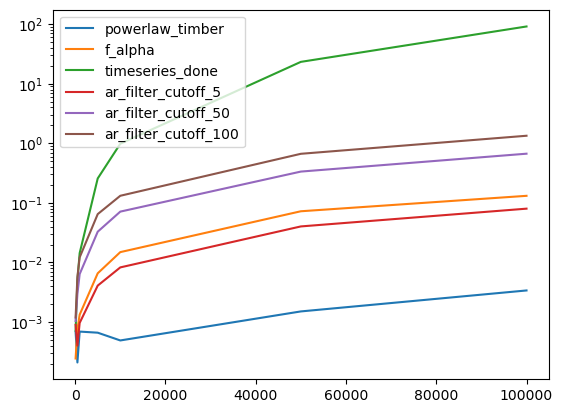

In [ ]:
import os
import time
n = 10000
T = 1.0 / n
generators = [
    ("powerlaw_timber", lambda alpha, n: powerlaw_psd_gaussian(alpha, n)),
    ("f_alpha", lambda alpha, n: f_alpha_noise(alpha, n)),
    ("timeseries_done", lambda alpha, n: timmer95_noise(alpha, n)),
    ("ar_filter_cutoff_5", lambda alpha, n: ar_filter_noise(alpha, n, 5)),
    ("ar_filter_cutoff_50", lambda alpha, n: ar_filter_noise(alpha, n, 50)),
    ("ar_filter_cutoff_100", lambda alpha, n: ar_filter_noise(alpha, n, 100)),
    #("timeseries_done_naive", lambda alpha, n: timmer95_noise_naive(alpha, n)),
]
alpha = 2
data = dict()
plt.figure()
for (gen_name,gen) in generators:
    data[gen_name] = []
    data["steps"] = [1e2,5e2,1e3,5e3,1e4,5e4,1e5]
    for n in data["steps"]:
        T = 1.0 / n
        start = time.time()
        for i in range(1):
            y = gen(alpha, int(n))
        end = time.time()
        print(f"{gen_name} with n={n} done in {end - start}")
        data[gen_name].append((end - start))
    plt.plot(data["steps"], data[gen_name], label=gen_name)
        
        # with open(f"../time/{n}/{gen_name}-{alpha}.yaml", 'w') as file:
        #     file.write(f"time: {end - start}")
plt.yscale("log")
plt.legend()
os.makedirs(os.path.dirname(f"../time/{n}/combined/"), exist_ok = True)
plt.savefig(f"../time/{n}/combined/all.svg")
    
# plt.close()
